In [16]:
import torch

def iou(model, dataloader, device='cpu'):
    '''
    model: Instance of a PyTorch nn.Module class with a defined forward() function that takes images as inputs
    dataloader: PyTorch DataLoader object that represents the dataset we will compute IoU over
    device (optional): string naming the device for computation, only needs to be changed for GPU training/evaluation
    '''
    intersection_pixel_count = 0
    union_pixel_count = 0
    with torch.no_grad():
        for images, targets in dataloader:
            # images should be shape (N, 3, H, W) for N images in a batch
            # targets should be shape (N, 1, H, W) for N images in a batch
            images, targets = images.to(device), targets.to(device)
            predictions = model(images)
            # predictions may be shape (N, 1, H, W) or (N, 2, H, W) depending on choice of implementation and loss function
            if predictions.size(1) == 1:
                # single prediction channel, result from model already passed through sigmoid
                binary_predictions = predictions > 0.5 # set pixels with >0.5 probability to one
            else:
                # two prediction channels, index 1 represents positive/foreground class, need to pass through softmax first
                prediction_probabilities = torch.softmax(predictions, dim=1)
                binary_predictions = prediction_probabilities[:, 1] > 0.5
                binary_predictions = binary_predictions.unsqueeze(1) # return to shape (N, 1, H, W)
            # add to intersection and union counts
            intersection_pixel_count += torch.sum((binary_predictions*targets)>0).item()
            union_pixel_count += torch.sum((binary_predictions+targets)>0).item()
    # return IoU over the given dataset
    return intersection_pixel_count/union_pixel_count


Epoch 1/30: Training Loss: 0.9106; Validation Loss: 0.9092; Validation IoU: 0.0167
Epoch 2/30: Training Loss: 0.8808; Validation Loss: 0.9015; Validation IoU: 0.0143
Epoch 3/30: Training Loss: 0.8567; Validation Loss: 0.8859; Validation IoU: 0.0163
Epoch 4/30: Training Loss: 0.8300; Validation Loss: 0.8668; Validation IoU: 0.0141
Epoch 5/30: Training Loss: 0.7991; Validation Loss: 0.8414; Validation IoU: 0.0126
Epoch 6/30: Training Loss: 0.7713; Validation Loss: 0.8179; Validation IoU: 0.0138
Epoch 7/30: Training Loss: 0.7508; Validation Loss: 0.7910; Validation IoU: 0.0143
Epoch 8/30: Training Loss: 0.7281; Validation Loss: 0.7627; Validation IoU: 0.0133
Epoch 9/30: Training Loss: 0.7037; Validation Loss: 0.7321; Validation IoU: 0.0117
Epoch 10/30: Training Loss: 0.6768; Validation Loss: 0.7011; Validation IoU: 0.0095
Epoch 11/30: Training Loss: 0.6548; Validation Loss: 0.6785; Validation IoU: 0.0085
Epoch 12/30: Training Loss: 0.6404; Validation Loss: 0.6595; Validation IoU: 0.0072
E

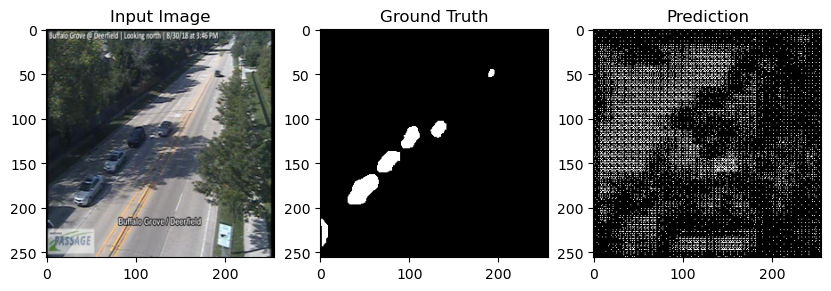

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from iou import iou
import matplotlib.pyplot as plt

# Dataset
class BFSDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_transform=None, annotation_transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_transform = image_transform
        self.annotation_transform = annotation_transform

        self.image_paths = []
        self.annotation_paths = []

        # Collect all image and annotation paths
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):  # Ensure we only process image files
                    image_path = os.path.join(root, file)
                    annotation_path = image_path.replace("Images", "Annotations").replace(".jpg", ".png")
                    self.image_paths.append(image_path)
                    self.annotation_paths.append(annotation_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        annotation_path = self.annotation_paths[idx]

        image = Image.open(image_path).convert("RGB")
        annotation = Image.open(annotation_path).convert("L")  # Grayscale mask

        if self.image_transform:
            image = self.image_transform(image)
        if self.annotation_transform:
            annotation = self.annotation_transform(annotation)

        # Convert annotation to binary
        annotation = (annotation > 0).float()  # Pixels > 0 are foreground

        return image, annotation

# Segmentation model
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        # Encoder for feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Decoder for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training loop
def training_loop(model, train_dataloader, validation_dataloader, optimizer, criterion, scheduler, device='cpu', epochs=30):
    model.to(device)
    metrics = {'train_loss': [], 'val_loss': [], 'val_iou': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, targets in train_dataloader:
            images, targets = images.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, targets in validation_dataloader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # Calculate IoU
        val_iou = iou(model, validation_dataloader, device=device)

        # Track and print metrics
        metrics['train_loss'].append(train_loss / len(train_dataloader))
        metrics['val_loss'].append(val_loss / len(validation_dataloader))
        metrics['val_iou'].append(val_iou)
        print(f"Epoch {epoch+1}/{epochs}: Training Loss: {train_loss/len(train_dataloader):.4f}; Validation Loss: {val_loss/len(validation_dataloader):.4f}; Validation IoU: {val_iou:.4f}")

        scheduler.step()

    return model, metrics

if __name__ == "__main__":
    image_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize images
        transforms.ToTensor()
    ])

    annotation_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),  # Resize annotations with nearest neighbor
        transforms.ToTensor()
    ])

    # Directory paths
    image_dir = r"C:\\Users\\siddh\\Desktop\\ECE 364\\BFSData\\Images"
    annotation_dir = r"C:\\Users\\siddh\\Desktop\\ECE 364\\BFSData\\Annotations"

    # Scene names
    scenes = [
        "Buffalo Grove at Deerfield East",
        "Buffalo Grove at Deerfield North",
        "Buffalo Grove at Deerfield South",
        "Buffalo Grove at Deerfield West"
    ]

    # Training and validation set loading
    dataset = BFSDataset(image_dir, annotation_dir, image_transform=image_transform, annotation_transform=annotation_transform)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)  # Shuffle indices for randomness

    half_size = len(indices) // 2
    train_indices = indices[:half_size]
    val_indices = indices[half_size:]

    # Dataloaders for training and validation
    train_loader = DataLoader(dataset, batch_size=16, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(dataset, batch_size=16, sampler=SubsetRandomSampler(val_indices))

    # Create per-scene datasets and dataloaders for validation IoU
    per_scene_val_loaders = {}
    for scene in scenes:
        scene_image_dir = os.path.join(image_dir, scene)
        scene_annotation_dir = os.path.join(annotation_dir, scene)
        scene_dataset = BFSDataset(scene_image_dir, scene_annotation_dir, image_transform=image_transform, annotation_transform=annotation_transform)
        scene_loader = DataLoader(scene_dataset, batch_size=16, shuffle=False)
        per_scene_val_loaders[scene] = scene_loader

    # Model, BCE loss, Adam optimizer
    model = SegmentationModel()
    criterion = nn.BCEWithLogitsLoss()  # Using logits
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Use Adam optimizer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce learning rate every 5 epochs

    # Train model
    trained_model, metrics = training_loop(model, train_loader, val_loader, optimizer, criterion, scheduler, device='cpu', epochs=30)

    # Calculate IoU for each scene
    print("Per-Scene Validation IoU:")
    for scene, loader in per_scene_val_loaders.items():
        scene_iou = iou(trained_model, loader, device='cpu')
        print(f"{scene}: {scene_iou:.4f}")

    # Visualize predictions
    model.eval()
    with torch.no_grad():
        images, targets = next(iter(val_loader))
        outputs = torch.sigmoid(model(images))  # Apply sigmoid during evaluation
        outputs = (outputs > 0.5).float()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[0].permute(1, 2, 0))  # RGB
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(targets[0][0].cpu(), cmap="gray")  # Mask
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(outputs[0][0].cpu(), cmap="gray")  # Prediction
        plt.show()
